## 1. Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from dotenv import load_dotenv

load_dotenv()

# Add the parent directory of src to sys.path
sys.path.append(os.path.abspath(os.path.join('..')))

from src.data.read_data import load_data
from src.visualization.helper_visualizations import analyze_target_distribution
from src.features.feature_encoder import LabelEncoderWrapper 


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

%matplotlib inline

## 2. Data load

In [2]:
# Retrieve file paths from environment variables
churn_data_path = os.getenv('CHURN_DATASET')

# Load datasets into pandas DataFrames
churn_df = load_data(churn_data_path)

In [3]:
pd.set_option('display.max_columns', None)
churn_df.head()
#pd.reset_option('display.max_columns')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3. Exploratory data analysis and data quality assessment

In [4]:
for column in churn_df.drop(columns=['customerID', 'tenure', 'SeniorCitizen' ,'MonthlyCharges', 'TotalCharges']).columns:
    print(f"Number of unique categories for feature {column}: \n {churn_df[column].unique()}")

Number of unique categories for feature gender: 
 ['Female' 'Male']
Number of unique categories for feature Partner: 
 ['Yes' 'No']
Number of unique categories for feature Dependents: 
 ['No' 'Yes']
Number of unique categories for feature PhoneService: 
 ['No' 'Yes']
Number of unique categories for feature MultipleLines: 
 ['No phone service' 'No' 'Yes']
Number of unique categories for feature InternetService: 
 ['DSL' 'Fiber optic' 'No']
Number of unique categories for feature OnlineSecurity: 
 ['No' 'Yes' 'No internet service']
Number of unique categories for feature OnlineBackup: 
 ['Yes' 'No' 'No internet service']
Number of unique categories for feature DeviceProtection: 
 ['No' 'Yes' 'No internet service']
Number of unique categories for feature TechSupport: 
 ['No' 'Yes' 'No internet service']
Number of unique categories for feature StreamingTV: 
 ['No' 'Yes' 'No internet service']
Number of unique categories for feature StreamingMovies: 
 ['No' 'Yes' 'No internet service']
Numb

In [5]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
# Since TotalCharges is of type 'object' we will need to convert it to float

churn_df['TotalCharges'] = pd.to_numeric(churn_df['TotalCharges'], errors='coerce')

churn_df.isna().mean()

customerID          0.000000
gender              0.000000
SeniorCitizen       0.000000
Partner             0.000000
Dependents          0.000000
tenure              0.000000
PhoneService        0.000000
MultipleLines       0.000000
InternetService     0.000000
OnlineSecurity      0.000000
OnlineBackup        0.000000
DeviceProtection    0.000000
TechSupport         0.000000
StreamingTV         0.000000
StreamingMovies     0.000000
Contract            0.000000
PaperlessBilling    0.000000
PaymentMethod       0.000000
MonthlyCharges      0.000000
TotalCharges        0.001562
Churn               0.000000
dtype: float64

In [7]:
churn_df.dropna(subset=['TotalCharges'], inplace=True)

Percentage of each category in 'Churn':
No: 73.42%
Yes: 26.58%


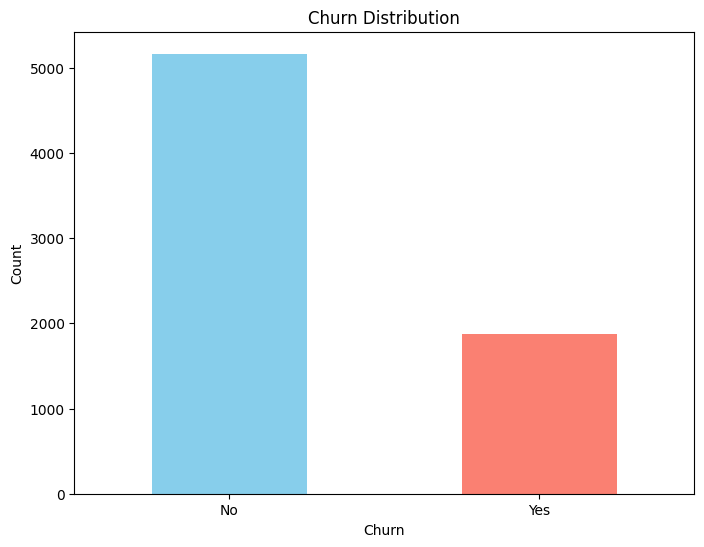

In [8]:
analyze_target_distribution(churn_df, 'Churn')

## 4. Machine Learning

In [9]:
encoder = LabelEncoderWrapper()
cols = churn_df.drop(columns=['customerID', 'tenure', 'SeniorCitizen' ,'MonthlyCharges', 'TotalCharges']).columns

  # Apply the fit_transform method
df_transformed = encoder.fit_transform(churn_df.copy(), cols)
print("Transformed DataFrame:")
df_transformed.head()

# Apply the inverse_transform method
#df_reversed = encoder.inverse_transform(df_transformed.copy())
#print("\nReversed DataFrame:")
#print(df_reversed)

Transformed DataFrame:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,5575-GNVDE,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,3668-QPYBK,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,7795-CFOCW,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,9237-HQITU,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [10]:
# Split data into training and test sets
X = df_transformed.drop(columns= ['customerID','Churn'], axis=1)
y = df_transformed['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Define sampling techniques
oversample = RandomOverSampler()
undersample = RandomUnderSampler()
smote = SMOTE()

# Define a simple pipeline with RandomForestClassifier
model = RandomForestClassifier(random_state=42)

In [12]:
# Original data
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Original Data Performance")
print(classification_report(y_test, y_pred))

Original Data Performance
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.63      0.48      0.54       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407



In [13]:
# Oversampling
pipeline = Pipeline(steps=[('over', oversample), ('model', model)])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Oversampling Performance")
print(classification_report(y_test, y_pred))

Oversampling Performance
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1033
           1       0.58      0.55      0.57       374

    accuracy                           0.78      1407
   macro avg       0.71      0.70      0.71      1407
weighted avg       0.77      0.78      0.77      1407



In [14]:
# Undersampling
pipeline = Pipeline(steps=[('under', undersample), ('model', model)])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Undersampling Performance")
print(classification_report(y_test, y_pred))

Undersampling Performance
              precision    recall  f1-score   support

           0       0.88      0.71      0.79      1033
           1       0.48      0.74      0.58       374

    accuracy                           0.72      1407
   macro avg       0.68      0.73      0.69      1407
weighted avg       0.78      0.72      0.73      1407



In [15]:
# SMOTE
pipeline = Pipeline(steps=[('smote', smote), ('model', model)])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("SMOTE Performance")
print(classification_report(y_test, y_pred))

SMOTE Performance
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1033
           1       0.57      0.56      0.57       374

    accuracy                           0.77      1407
   macro avg       0.71      0.70      0.71      1407
weighted avg       0.77      0.77      0.77      1407

